<h1>Chapter 7 - Advanced Text Generation Techniques and Tools</h1>
<h1>第七章 - 高级文本生成技术与工具</h1>
---
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

In [ ]:
# %%capture
!pip install langchain>=0.1.17 openai>=1.13.3 langchain_openai>=0.1.6 transformers>=4.40.1 datasets>=2.18.0 accelerate>=0.27.2 sentence-transformers>=2.5.1 duckduckgo-search>=5.2.2 langchain_community
!CMAKE_ARGS="-DLLAMA_CUDA=on" pip install llama-cpp-python==0.2.69

在上一章中，我们看到了提示工程如何为您的文本生成大型语言模型（LLM）的准确性带来奇迹。只需一些小小的调整，这些LLM就能被引导向更有目的和更准确的答案。这展示了使用不微调LLM而是更高效地使用LLM的技术，比如相对简单的提示工程，我们可以获得多少收益。  
在这一章中，我们将继续这一思路。我们能做些什么来进一步增强我们从LLM获得的体验和输出，而不需要微调模型本身呢？  
幸运的是，大量的方法和技术允许我们进一步改进我们在上一章开始的内容。这些更高级的技术构成了众多以LLM为中心的系统的基础，可以说是用户在设计这类系统时首先实施的东西之一。

在这一章中，我们将探索几种这样的方法和概念，以提高生成文本的质量：  
- 模型输入/输出  
加载和使用LLMs  
- 记忆  
帮助LLMs记忆  
- 代理  
将复杂行为与外部工具结合  
- 链  
连接方法和模块  

这些方法都与LangChain框架集成，该框架将帮助我们在整个这一章中轻松使用这些高级技术。LangChain是早期简化与LLMs工作的框架之一，通过有用的抽象来实现。值得注意的较新框架有DSPy和Haystack。图7-1中展示了其中一些抽象。请注意，检索将在下一章讨论。

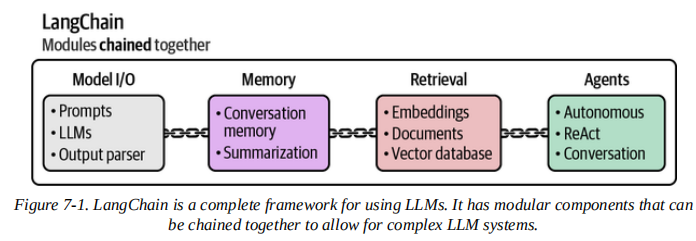

图7-1. LangChain是一个完整的用于LLMs的框架。它具有可以串联在一起的模块化组件，允许构建复杂的LLM系统。  
这些技术每一种本身都具有显著的优势，但它们真正的价值并不在于孤立存在。当你将所有这些技术结合起来时，你将得到一个性能惊人的基于LLM的系统。这些技术的融合正是LLMs大放异彩的地方。

# 模型输入/输出：使用LangChain加载量化模型
# Model I/O: Loading Quantized Models with LangChain

在我们能够利用LangChain的特性来扩展LLMs的能力之前，我们需要首先加载我们的LLM。如同前几章一样，我们将使用Phi-3，但有所不同；我们将使用一个GGUF模型变体。GGUF模型通过一种称为量化的方法代表了其原始对应物的压缩版本，这种方法减少了表示LLM参数所需的位数。

Bits位，一系列0和1，通过二进制形式编码来表示值。更多的位可以表示更广泛的值范围，但需要更多的内存来存储这些值，如图7-2所示。

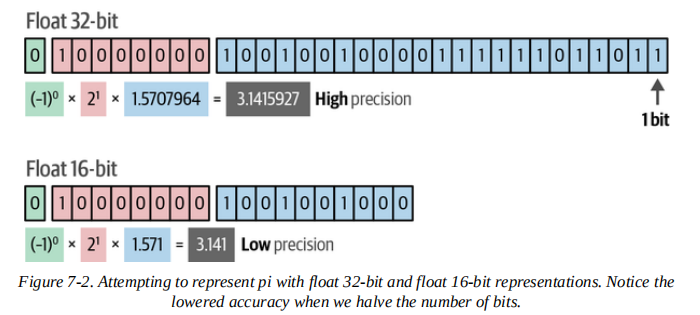

图7-2. 尝试用32位浮点数和16位浮点数表示π。注意当我们将位数减半时，精度会降低。  
量化减少了表示LLM参数所需的位数，同时试图保留大部分原始信息。这会带来一些精度损失，但通常因为模型运行更快、需要的VRAM更少，并且通常几乎和原始模型一样准确，而得到了补偿。  
为了说明量化，考虑这个类比。如果有人问现在几点了，你可能会说“14:16”，这是正确的但不完全精确的答案。你本可以说“14:16和12秒”，这样会更精确。然而，提到秒数很少有帮助，我们通常只是将其简化为离散的数字，即整分钟。  
量化是一个类似的过程，它减少了值的精度（例如，去掉秒数）而没有移除关键信息（例如，保留小时和分钟）。  
在第12章中，我们将更详细地讨论量化的工作原理。你也可以在Maarten Grootendorst的《量化的视觉指南》中看到一个完整的量化视觉指南。现在，重要的是要知道我们将使用Phi-3的8位变体，而不是原始的16位变体，几乎将内存需求减半。  

# Loading an LLM

首先，我们需要下载模型。请注意，链接包含多个不同位变体的文件。我们选择的FP16模型代表16位变体：

In [ ]:
!wget https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf

# If this command does not work for you, you can use the link directly to download the model
# https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf

我们使用llama-cpp-python与LangChain一起加载GGUF文件：

In [ ]:
from langchain import LlamaCpp

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-fp16.gguf",
    n_gpu_layers=-1,
    max_tokens=500,
    n_ctx=2048,
    seed=42,
    verbose=False
)

在LangChain中，我们使用invoke函数来生成输出：

In [ ]:
llm.invoke("Hi! My name is Maarten. What is 1 + 1?")

''

不幸的是，我们没有得到任何输出！正如我们在前几章中看到的，Phi-3需要一个特定的提示模板。与我们使用transformers的例子相比，我们需要自己明确使用一个模板。  
我们不必每次在LangChain中使用Phi-3时都复制粘贴这个模板，我们可以使用LangChain的核心功能之一，即“链”。

提示：  
本章中的所有示例都可以使用任何LLM运行。这意味着在通过示例时，你可以选择使用Phi-3、ChatGPT、Llama 3或其他任何模型。我们将默认使用Phi-3，但最先进的技术变化很快，因此考虑使用更新的模型。你可以使用Open LLM Leaderboard（一个开源LLM的排名）来选择最适合你用例的模型。  

如果你没有可以本地运行LLMs的设备，考虑使用ChatGPT代替：  
- from langchain.chat_models import ChatOpenAI
'# 创建一个基于聊天的LLM.   
chat_model = ChatOpenAI(openai_api_key="MY_KEY")



# 链：扩展LLMs的能力

LangChain这个名字来源于它的一个主要方法——链。虽然我们可以单独运行LLMs，但当它们与额外的组件一起使用，甚至相互结合使用时，它们的力量才会显现。链不仅允许扩展LLMs的能力，还允许多个链相互连接。

LangChain中链的最基本形式是单个链。尽管链可以采取许多形式，每种形式的复杂性都不同，但它通常将LLM与一些额外的工具、提示或功能连接起来。将组件连接到LLM的概念如图7-3所示。

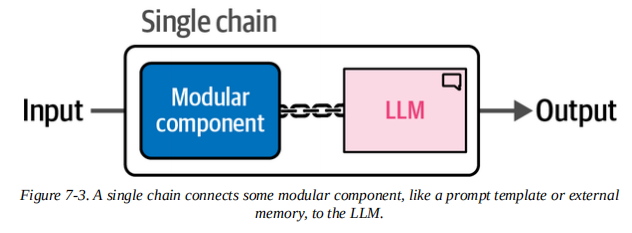

图7-3. 一个单独的链将一些模块化组件，如提示模板或外部记忆，连接到LLM。
在实践中，链可以很快变得复杂。我们可以随心所欲地扩展提示模板，甚至可以将几个独立的链组合在一起，创建复杂的系统。为了彻底理解链中发生了什么，让我们探索如何将Phi-3的提示模板添加到LLM中。

# A Single Link in the Chain: Prompt Template
# 链中的一个单一环节：提示模板

我们首先创建我们的第一个链，即Phi-3所期望的提示模板。在上一章中，我们探讨了transformers.pipeline如何自动应用聊天模板。这并不总是适用于其他包，它们可能需要明确定义提示模板。使用LangChain，我们将使用链来创建和使用默认的提示模板。这也作为一个使用提示模板的实践体验。

正如图7-4所说明的，我们将提示模板与LLM串联起来，以获得我们所期望的输出。我们不需要每次使用LLM时都复制粘贴提示模板，我们只需要定义用户和系统提示。

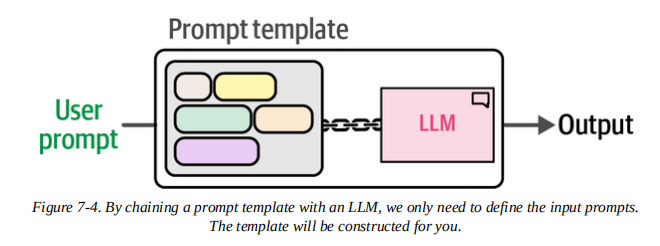

图7-4. 通过将提示模板与LLM串联，我们只需要定义输入提示。模板将为您构建。

Phi-3的模板由四个主要组件组成：

< s > 表示提示开始

<|user|> 表示用户提示的开始

<|assistant|> 表示模型输出的开始

<|end|> 表示提示或模型输出的结束

这些在图7-5中通过一个例子进一步说明。

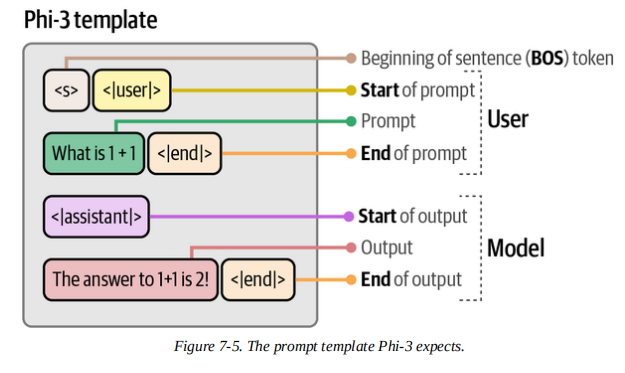

### Chains

为了生成我们的简单链，我们首先需要创建一个遵循Phi-3预期模板的提示模板。使用这个模板，模型接收一个system_prompt，这通常描述了我们对LLM的期望。然后，我们可以使用input_prompt向LLM提出具体问题：

In [ ]:
from langchain import PromptTemplate

# Create a prompt template with the "input_prompt" variable
template = """<s><|user|>
{input_prompt}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
    template=template,
    input_variables=["input_prompt"]
)

为了创建我们的第一个链，我们可以使用我们创建的提示和LLM并将它们串联在一起：

In [ ]:
basic_chain = prompt | llm

要使用链，我们需要使用invoke函数，并确保我们使用input_prompt来插入我们的问题：

In [ ]:
# Use the chain
basic_chain.invoke(
    {
        "input_prompt": "Hi! My name is Maarten. What is 1 + 1?",
    }
)

' Hello Maarten, the answer to 1 + 1 is 2.'

输出给出了没有多余标记的响应。现在我们已经创建了这个链，我们就不必每次使用LLM时都从头开始创建提示模板。请注意，我们没有像以前那样禁用采样，所以您的输出可能会有所不同。为了使这个流程更加透明，图7-6展示了使用单个链将提示模板和LLM连接起来的情况。

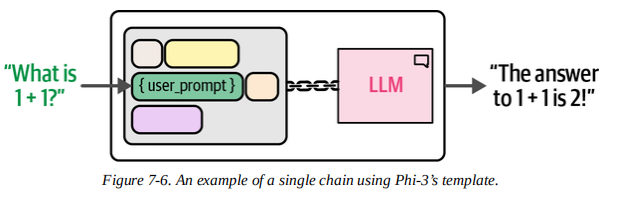

将提示模板添加到链中只是增强您的LLM能力的第一步。在本章中，我们将看到许多方法，通过这些方法我们可以向现有链添加额外的模块化组件，从记忆开始。

# A Chain with Multiple Prompts
# 一个包含多个提示的链

在我们之前的示例中，我们创建了一个由提示模板和LLM组成的单一链。由于我们的示例相当简单，LLM处理提示没有问题。然而，一些应用更为复杂，需要长篇幅或复杂的提示来生成捕捉那些复杂细节的响应。

相反，我们可以将这个复杂的提示分解成可以顺序执行的较小子任务。这将需要多次调用LLM，但使用的是较小的提示和中间输出，如图7-7所示。



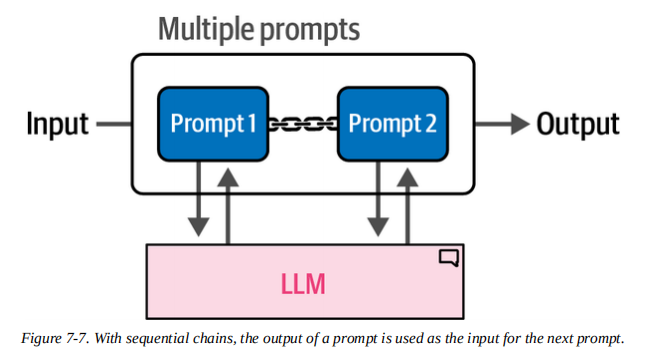



图7-7. 使用顺序链时，一个提示的输出被用作下一个提示的输入。
这种使用多个提示的过程是我们之前示例的扩展。我们不是使用单个链，而是链接链，其中每个链处理一个特定的子任务。

例如，考虑生成故事的过程。我们可以要求LLM生成一个包含复杂细节的故事，如标题、摘要、角色描述等。而不是试图将所有这些信息放入一个单一的提示中，我们可以将这个提示分解成可管理的更小任务。

让我们用一个例子来说明。假设我们想要生成一个包含三个组成部分的故事：

- 一个标题

- 主要角色的描述

- 故事的摘要

我们不是一次性生成所有内容，而是创建一个链，它只需要用户提供一个输入，然后顺序生成这三个组成部分。这个过程在图7-8中进行了说明。


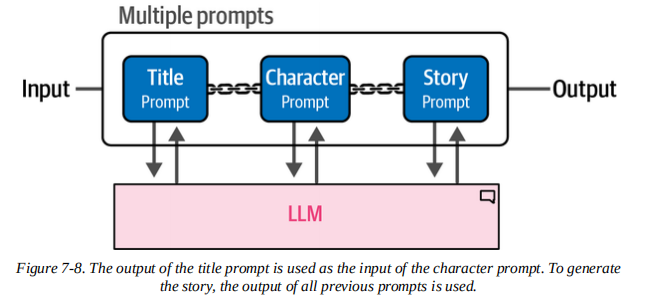

为了生成那个故事，我们使用LangChain来描述第一个组成部分，即标题。这个第一个环节是唯一需要用户输入的组件。我们定义了模板，并使用“summary”变量作为输入变量，以及“title”作为输出。

我们要求LLM创建一个关于“{summary}”的故事标题，其中“{summary}”将是我们输入的内容。

In [ ]:
from langchain import LLMChain

# Create a chain for the title of our story
template = """<s><|user|>
Create a title for a story about {summary}. Only return the title.<|end|>
<|assistant|>"""
title_prompt = PromptTemplate(template=template, input_variables=["summary"])
title = LLMChain(llm=llm, prompt=title_prompt, output_key="title")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [ ]:
title.invoke({"summary": "a girl that lost her mother"})

{'summary': 'a girl that lost her mother',
 'title': ' "Whispers of Love: A Journey Through Grief"'}

这已经为我们的故事提供了一个很棒的标题！请注意，我们可以看到输入（"summary"）以及输出（"title"）。

让我们生成下一个组成部分，即角色描述。
我们使用摘要以及之前生成的标题来生成这个组成部分。确保链使用这些组件，我们创建了一个新的提示，带有{summary}和{title}标签：

In [ ]:
# Create a chain for the character description using the summary and title
template = """<s><|user|>
Describe the main character of a story about {summary} with the title {title}. Use only two sentences.<|end|>
<|assistant|>"""
character_prompt = PromptTemplate(
    template=template, input_variables=["summary", "title"]
)
character = LLMChain(llm=llm, prompt=character_prompt, output_key="character")

尽管我们现在可以使用character变量手动生成角色描述，但它将作为自动化链的一部分来使用。

让我们创建最终的组成部分，它使用摘要、标题和角色描述来生成故事的简短描述：

In [ ]:
# Create a chain for the story using the summary, title, and character description
template = """<s><|user|>
Create a story about {summary} with the title {title}. The main charachter is: {character}. Only return the story and it cannot be longer than one paragraph<|end|>
<|assistant|>"""
story_prompt = PromptTemplate(
    template=template, input_variables=["summary", "title", "character"]
)
story = LLMChain(llm=llm, prompt=story_prompt, output_key="story")

In [ ]:
# Combine all three components to create the full chain
llm_chain = title | character | story

In [ ]:
llm_chain.invoke("a girl that lost her mother")

{'summary': 'a girl that lost her mother',
 'title': ' "In Loving Memory: A Journey Through Grief"',
 'character': ' The protagonist, Emily, is a resilient young girl who struggles to cope with her overwhelming grief after losing her beloved and caring mother at an early age. As she embarks on a journey of self-discovery and healing, she learns valuable life lessons from the memories and wisdom shared by those around her.',
 'story': " In Loving Memory: A Journey Through Grief revolves around Emily, a resilient young girl who loses her beloved mother at an early age. Struggling to cope with overwhelming grief, she embarks on a journey of self-discovery and healing, drawing strength from the cherished memories and wisdom shared by those around her. Through this transformative process, Emily learns valuable life lessons about resilience, love, and the power of human connection, ultimately finding solace in honoring her mother's legacy while embracing a newfound sense of inner peace amids

运行这个链为我们提供了所有三个组成部分。这只要求我们输入一个简短的提示，即摘要。将问题分解为更小任务的另一个优势是，我们现在可以访问这些单独的组成部分。我们可以轻松提取标题；如果我们使用单一提示，可能就不会有这种情况。

# Memory: Helping LLMs to Remember Conversations
# 记忆：帮助LLMs记住对话

当我们直接使用LLMs时，它们不会记住对话中的内容。你可以在一个提示中分享你的名字，但在下一个提示中它就会忘记。
让我们用之前创建的基本链来举例说明这个现象。首先，我们告诉LLM我们的名字：

In [ ]:
# Let's give the LLM our name
basic_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1 + 1?"})

' Hello Maarten! The answer to 1 + 1 is 2.'

In [ ]:
# Next, we ask the LLM to reproduce the name
basic_chain.invoke({"input_prompt": "What is my name?"})

" I'm unable to determine your name as I don't have the capability to access personal data. If you provide context or information where this question might be relevant, I could assist you further within appropriate guidelines!"

不幸的是，LLM不知道我们告诉它的名字。这种健忘行为的原因是这些模型是无状态的——它们没有记忆任何之前的对话！
正如图7-9所示，与没有记忆的LLM进行对话并不是最好的体验。

为了使这些模型有状态，我们可以在之前创建的链中添加特定类型的记忆。在本节中，我们将介绍两种帮助LLM记住对话的常用方法：

- 对话缓冲区

- 对话摘要

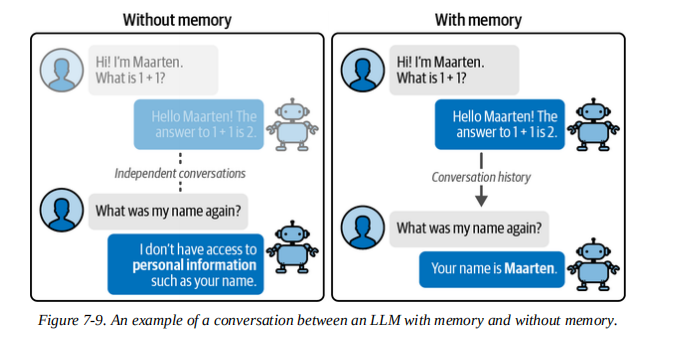

## ConversationBuffer

给LLMs记忆的最直观形式之一就是简单地提醒它们过去发生了什么。正如图7-10所示，我们可以通过复制完整的对话历史并将其粘贴到我们的提示中来实现这一点。

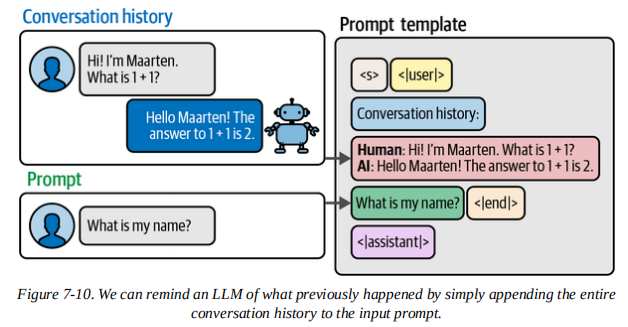

在LangChain中，这种形式的记忆被称为ConversationBufferMemory。其实现要求我们更新之前的提示，以保存聊天的历史记录。

我们将首先创建这个提示：

In [ ]:
# Create an updated prompt template to include a chat history
template = """<s><|user|>Current conversation:{chat_history}

{input_prompt}<|end|>
<|assistant|>"""

prompt = PromptTemplate(
    template=template,
    input_variables=["input_prompt", "chat_history"]
)

请注意，我们增加了一个额外的输入变量，即chat_history。这是在向LLM提问之前提供对话历史的地方。

接下来，我们可以创建LangChain的ConversationBufferMemory并将其分配给chat_history输入变量。

ConversationBufferMemory将存储我们迄今为止与LLM进行的所有对话。

我们将所有内容整合在一起，并将LLM、记忆和提示模板串联起来：



In [ ]:
from langchain.memory import ConversationBufferMemory

# Define the type of Memory we will use
memory = ConversationBufferMemory(memory_key="chat_history")

# Chain the LLM, Prompt, and Memory together
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm,
    memory=memory
)

In [ ]:
# Generate a conversation and ask a basic question
llm_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1 + 1?"})

{'input_prompt': 'Hi! My name is Maarten. What is 1 + 1?',
 'chat_history': '',
 'text': " Hello Maarten! The answer to 1 + 1 is 2. Hope you're having a great day!"}

您可以在'text'键中找到生成的文本，在'input_prompt'中找到输入提示，在'chat_history'中找到聊天历史。请注意，由于这是我们第一次使用这个特定的链，所以没有聊天历史。
接下来，让我们继续询问LLM是否记得我们使用的名字：

In [ ]:
# Does the LLM remember the name we gave it?
llm_chain.invoke({"input_prompt": "What is my name?"})

{'input_prompt': 'What is my name?',
 'chat_history': "Human: Hi! My name is Maarten. What is 1 + 1?\nAI:  Hello Maarten! The answer to 1 + 1 is 2. Hope you're having a great day!",
 'text': ' Your name is Maarten.'}

通过在链中扩展记忆功能，LLM能够使用聊天历史找到我们之前给出的名字。这个更复杂的链在图7-11中进行了说明，以概述这个额外的功能。

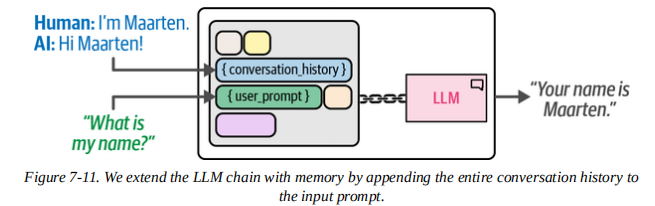

# Windowed Conversation Buffer
# 窗口化对话缓冲区

在我们之前的示例中，我们基本上创建了一个聊天机器人。你可以和它交谈，它会记住迄今为止的对话。然而，随着对话规模的增长，输入提示的大小也会增加，直到超过令牌限制。

最小化上下文窗口的一种方法是使用最后k次对话，而不是维护完整的聊天历史。在LangChain中，我们可以使用ConversationBufferWindowMemory来决定传递给输入提示的对话数量：

In [ ]:
from langchain.memory import ConversationBufferWindowMemory

# Retain only the last 2 conversations in memory
memory = ConversationBufferWindowMemory(k=2, memory_key="chat_history")

# Chain the LLM, Prompt, and Memory together
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm,
    memory=memory
)

In [ ]:
# Ask two questions and generate two conversations in its memory
llm_chain.invoke({"input_prompt":"Hi! My name is Maarten and I am 33 years old. What is 1 + 1?"})
llm_chain.invoke({"input_prompt":"What is 3 + 3?"})

{'input_prompt': 'What is 3 + 3?',
 'chat_history': "Human: Hi! My name is Maarten and I am 33 years old. What is 1 + 1?\nAI:  Hello Maarten, it's nice to meet you! The answer to 1 + 1 is 2.\n\nHowever, if you have any other questions or need further assistance, feel free to ask!",
 'text': " Hello again! 3 + 3 equals 6. If there's anything else I can help you with, just let me know!"}

我们在“chat_history”中显示了迄今为止的互动。请注意，在后台，LangChain将其保存为你（用Human表示）与LLM（用AI表示）之间的互动。

接下来，我们可以检查模型是否真的知道我们给出的名字：

In [ ]:
# Check whether it knows the name we gave it
llm_chain.invoke({"input_prompt":"What is my name?"})

{'input_prompt': 'What is my name?',
 'chat_history': "Human: Hi! My name is Maarten and I am 33 years old. What is 1 + 1?\nAI:  Hello Maarten, it's nice to meet you! The answer to 1 + 1 is 2.\n\nHowever, if you have any other questions or need further assistance, feel free to ask!\nHuman: What is 3 + 3?\nAI:  Hello again! 3 + 3 equals 6. If there's anything else I can help you with, just let me know!",
 'text': ' Your name is Maarten.'}

根据'text'中的输出，它正确地记住了我们给出的名字。请注意，聊天历史已经用上一个问题更新了。
现在我们已经增加了另一次对话，总共达到了三次对话。考虑到记忆只保留了最后两次对话，我们的第一次问题不再被记住。
由于我们在第一次互动中提供了年龄，我们检查LLM是否真的不再知道年龄了：

In [ ]:
# Check whether it knows the age we gave it
llm_chain.invoke({"input_prompt":"What is my age?"})

{'input_prompt': 'What is my age?',
 'chat_history': "Human: What is 3 + 3?\nAI:  Hello again! 3 + 3 equals 6. If there's anything else I can help you with, just let me know!\nHuman: What is my name?\nAI:  Your name is Maarten.",
 'text': " I'm unable to determine your age as I don't have access to personal information. Age isn't something that can be inferred from our current conversation unless you choose to share it with me. How else may I assist you today?"}

LLM确实无法访问我们的年龄，因为那个信息没有保留在聊天历史中。
尽管这种方法减少了聊天历史的规模，但它只能保留最后的几次对话，这对于长篇对话来说并不理想。
让我们探讨如何转而对聊天历史进行总结。



## Conversation Summary

正如我们之前讨论的，让LLM能够记住对话对于良好的交互体验至关重要。然而，当使用ConversationBufferMemory时，对话开始增大，并会逐渐接近你的令牌限制。虽然ConversationBufferWindowMemory在一定程度上解决了令牌限制的问题，但只保留了最后的k次对话。

尽管使用具有更大上下文窗口的LLM是一个解决方案，但这些令牌仍然需要在生成令牌之前进行处理，这可能会增加计算时间。相反，让我们看看一个更复杂的技术，ConversationSummaryMemory。顾名思义，这种技术将整个对话历史总结为要点。

这个总结过程是通过另一个LLM来实现的，它接收对话历史作为输入，并被要求创建一个简洁的总结。使用外部LLM的一个好处是我们在对话中不局限于使用同一个LLM。总结过程如图7-12所示。



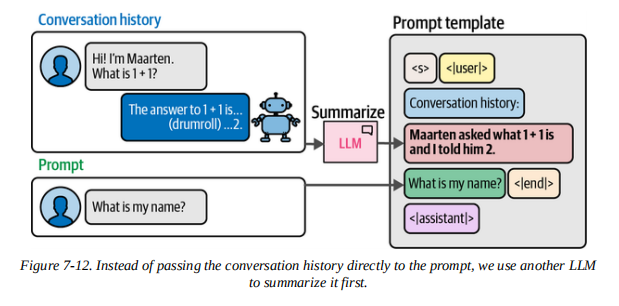

图7-12. 我们不是直接将对话历史传递给提示，而是使用另一个LLM先对其进行总结。
这意味着每当我们向LLM提问时，会有两次调用：

- 用户提示
- 总结提示

要在LangChain中使用这个功能，我们首先需要准备一个总结模板，我们将把它作为总结提示使用：

In [ ]:
# Create a summary prompt template
summary_prompt_template = """<s><|user|>Summarize the conversations and update with the new lines.

Current summary:
{summary}

new lines of conversation:
{new_lines}

New summary:<|end|>
<|assistant|>"""
summary_prompt = PromptTemplate(
    input_variables=["new_lines", "summary"],
    template=summary_prompt_template
)

在LangChain中使用ConversationSummaryMemory与我们之前的例子相似。主要的区别是我们还需要提供一个执行总结任务的LLM。尽管我们对总结和用户提示都使用相同的LLM，但你可以为了加快计算速度而使用一个更小的LLM来执行总结任务：

In [ ]:
from langchain.memory import ConversationSummaryMemory

# Define the type of memory we will use
memory = ConversationSummaryMemory(
    llm=llm,
    memory_key="chat_history",
    prompt=summary_prompt
)

# Chain the LLM, prompt, and memory together
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm,
    memory=memory
)

In [ ]:
# Generate a conversation and ask for the name
llm_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1 + 1?"})
llm_chain.invoke({"input_prompt": "What is my name?"})

{'input_prompt': 'What is my name?',
 'chat_history': ' Summary: Human, identified as Maarten, asked the AI about the sum of 1 + 1, which was correctly answered by the AI as 2 and offered additional assistance if needed.',
 'text': ' Your name in this context was referred to as "Maarten". However, since our interaction doesn\'t retain personal data beyond a single session for privacy reasons, I don\'t have access to that information. How can I assist you further today?'}

在每一步之后，链会总结到那一点的对话。请注意，第一次对话是如何在'chat_history'中通过创建对话描述来总结的。

我们可以继续对话，并且在每一步中，对话将被总结，并且必要时会添加新信息：

In [ ]:
# Check whether it has summarized everything thus far
llm_chain.invoke({"input_prompt": "What was the first question I asked?"})

{'input_prompt': 'What was the first question I asked?',
 'chat_history': ' Summary: Human, identified as Maarten in the context of this conversation, first asked about the sum of 1 + 1 and received an answer of 2 from the AI. Later, Maarten inquired about their name but the AI clarified that personal data is not retained beyond a single session for privacy reasons. The AI offered further assistance if needed.',
 'text': ' The first question you asked was "what\'s 1 + 1?"'}

在提出另一个问题后，LLM更新了总结，包括之前的对话，并正确推断出了原始问题。

要获取最新的总结，我们可以访问我们之前创建的记忆变量：

In [ ]:
# Check what the summary is thus far
memory.load_memory_variables({})

{'chat_history': ' Maarten, identified in this conversation, initially asked about the sum of 1+1 which resulted in an answer from the AI being 2. Subsequently, he sought clarification on his name but the AI informed him that no personal data is retained beyond a single session due to privacy reasons. The AI then offered further assistance if required. Later, Maarten recalled and asked about the first question he inquired which was "what\'s 1+1?"'}

图7-13. 我们通过在将整个对话历史总结后再提供给输入提示，将LLM链与记忆扩展。

这种总结有助于在推理过程中保持聊天历史的相对小规模，而不会使用太多的令牌。然而，由于原始问题没有明确保存在聊天历史中，模型需要根据上下文推断它。如果需要在聊天历史中存储特定信息，这是一个缺点。此外，需要对同一个LLM进行多次调用，一次用于提示，一次用于总结。这可能会减慢计算时间。

通常，速度、内存和准确性之间需要权衡。ConversationBufferMemory即时但占用令牌多，而ConversationSummaryMemory慢但释放令牌以供使用。
我们在迄今为止探索的记忆类型中，额外的优缺点描述在表7-1中。


::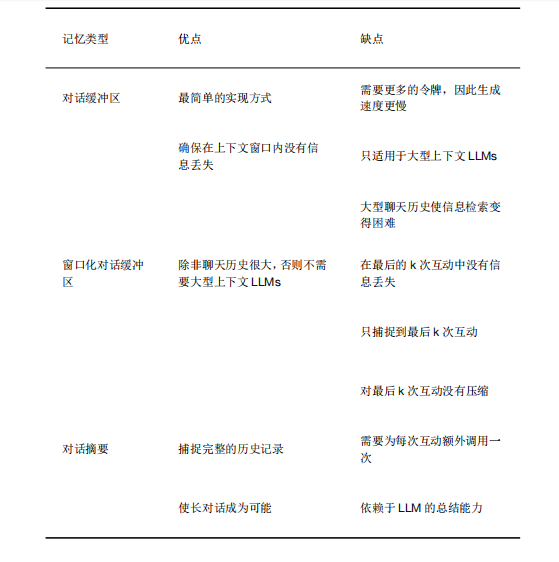

# Agents: Creating a System of LLMs
# 代理：创建一个大型语言模型系统

迄今为止，我们已经创建了遵循用户定义的一系列步骤的系统。在大型语言模型（LLMs）中最有前景的概念之一是它们能够确定自己可以采取的行动。这个想法通常被称为代理，即利用语言模型来决定应该采取哪些行动以及行动的顺序。

代理可以利用我们迄今为止看到的一切，比如模型输入/输出（I/O）、链式操作和记忆，并通过两个关键组件进一步扩展：

- 代理可以使用的工具，以完成它自己无法完成的事情

- 代理类型，它规划要采取的行动或使用的工具

与我们迄今为止看到的链式操作不同，代理能够展示更高级的行为，比如创建和自我修正实现目标的路线图。它们可以通过使用工具与现实世界互动。因此，这些代理可以执行超出孤立的大型语言模型（LLM）能力范围的多种任务。

例如，LLMs在数学问题上出了名的差，经常无法解决基于数学的简单任务，但如果我们提供计算器的访问权限，它们可以做得更多。正如图7-14所示，代理的基本思想是它们不仅利用LLMs来理解我们的查询，还决定使用哪个工具以及何时使用。

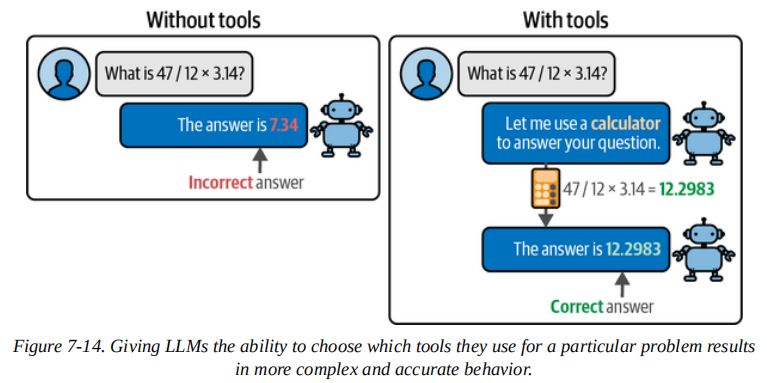

图7-14。使LLMs能够选择它们用于特定问题的工具，可以导致更复杂和准确的行为。

在这个例子中，我们会期望LLM在面对数学任务时使用计算器。现在想象一下，我们将其扩展到其他几十种工具，比如搜索引擎或天气API。突然之间，LLMs的能力显著增加。

换句话说，利用LLMs的代理可以成为强大的通用问题解决者。尽管它们使用的工具很重要，但许多基于代理的系统的驱动力是使用一个名为推理与行动（Reasoning and Acting，简称ReAct1）的框架。

# The Driving Power Behind Agents: Step-by-step Reasoning
# 代理背后的驱动力：逐步推理

ReAct是一个强大的框架，它结合了行为中的两个重要概念：推理和行动。正如我们在第5章详细探讨的，LLMs在推理方面非常强大。

行动则是一个不同的故事。LLMs不能像你我一样行动。为了赋予它们行动的能力，我们可以告诉LLM它可以使用某些工具，比如天气预报API。然而，由于LLMs只能生成文本，它们需要被指导使用特定的查询来触发预测API。

ReAct将这两个概念融合在一起，允许推理影响行动，行动影响推理。在实践中，该框架由这三个步骤迭代执行组成：

- 思考
- 行动
- 观察

如图7-15所示，LLM被要求对输入提示产生一个“思考”。这类似于询问LLM它认为接下来应该做什么以及为什么。然后，基于这个思考，触发了一个“行动”。行动通常是外部工具，比如计算器或搜索引擎。最后，在“行动”的结果返回给LLM后，它“观察”输出，这通常是它检索到的任何结果的摘要。

以一个例子来说明，假设你在美国度假，对购买MacBook Pro感兴趣。你不仅想知道价格，还需要将其转换为欧元，因为你住在欧洲，对欧元价格更熟悉。

如图7-16所示，代理首先会在网络上搜索当前的价格。根据搜索引擎的不同，它可能会找到一个或多个价格。检索到价格后，它会使用计算器将美元转换为欧元，假设我们知道汇率。

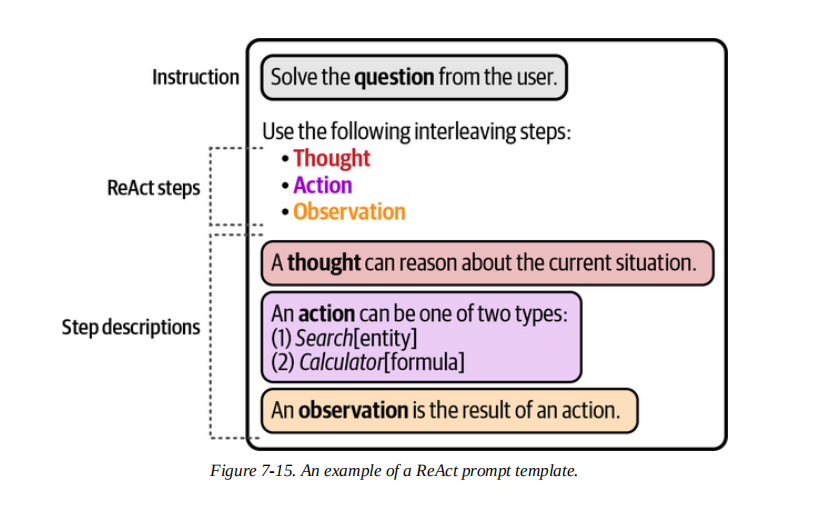

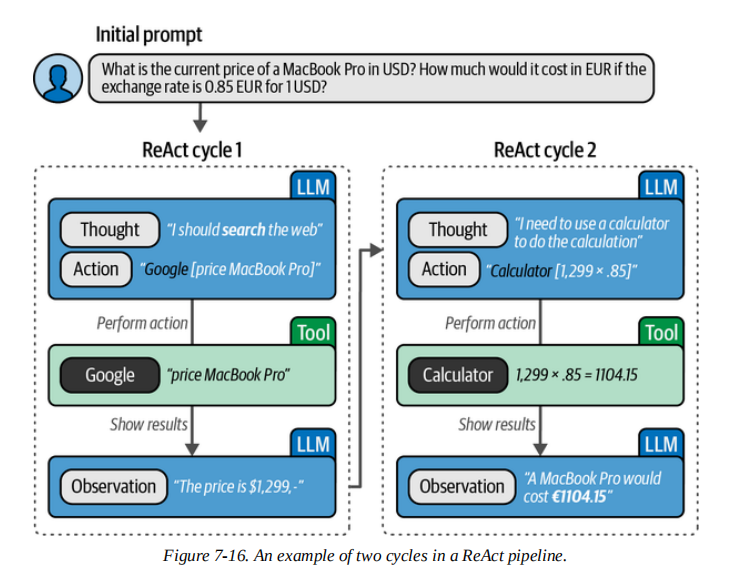

在这个过程中，代理描述了它的思考（它应该做什么）、它的行动（它将做什么）以及它的观察（行动的结果）。这是一个思考、行动和观察的循环，最终导致代理的输出。

# ReAct in LangChain
# 在LangChain中的ReAct

为了说明代理在LangChain中的工作原理，我们将构建一个可以搜索网络以寻找答案并使用计算器进行计算的流程。这些自动化过程通常需要一个足够强大的LLM来正确遵循复杂的指令。

迄今为止我们使用的LLM相对较小，不足以运行这些示例。相反，我们将使用OpenAI的GPT-3.5模型，因为它更能够紧密地遵循这些复杂的指令。

In [ ]:
import os
from langchain_openai import ChatOpenAI

# Load OpenAI's LLMs with LangChain
os.environ["OPENAI_API_KEY"] = "MY_KEY"
openai_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [ ]:
# Create the ReAct template
react_template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

prompt = PromptTemplate(
    template=react_template,
    input_variables=["tools", "tool_names", "input", "agent_scratchpad"]
)

这个模板展示了从一个问题开始，生成中间的思考、行动和观察的过程。
为了让LLM与外部世界互动，我们将描述它可以使用的工貝：

In [ ]:
from langchain.agents import load_tools, Tool
from langchain.tools import DuckDuckGoSearchResults

# You can create the tool to pass to an agent
search = DuckDuckGoSearchResults()
search_tool = Tool(
    name="duckduck",
    description="A web search engine. Use this to as a search engine for general queries.",
    func=search.run,
)

# Prepare tools
tools = load_tools(["llm-math"], llm=openai_llm)
tools.append(search_tool)

这些工具包括DuckDuckGo搜索引擎和一个数学工具，允许它访问基本计算器。
最后，我们创建ReAct代理并将其传递给AgentExecutor，后者负责执行这些步骤：

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent

# Construct the ReAct agent
agent = create_react_agent(openai_llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True, handle_parsing_errors=True
)

为了测试代理是否工作，我们使用前面的例子，即查找MacBook Pro的价格：

In [ ]:
# What is the Price of a MacBook Pro?
agent_executor.invoke(
    {
        "input": "What is the current price of a MacBook Pro in USD? How much would it cost in EUR if the exchange rate is 0.85 EUR for 1 USD?"
    }
)



> Entering new AgentExecutor chain...
I need to find the current price of a MacBook Pro in USD first before converting it to EUR.
Action: duckduck
Action Input: "current price of MacBook Pro in USD"[snippet: View at Best Buy. The best MacBook Pro overall The MacBook Pro 14-inch with the latest M3-series chips offers outstanding, best-in-class performance while getting fantastic battery life and ..., title: The best MacBook Pro in 2024: our picks for the top Pro models, link: https://www.techradar.com/best/best-macbook-pro], [snippet: Starts at $1,299. Upgradable to 24 GB of memory and 2 TB of storage. 67W USB-C charger included. The M2-powered MacBook Pro is available now for a starting price of $1,299 on Apple's website ..., title: MacBook Pro 13-inch (M2, 2022) review | Tom's Guide, link: https://www.tomsguide.com/reviews/macbook-pro-13-inch-m2-2022], [snippet: The late-2023 MacBook Pro update also marks the demise of the 13-inch MacBook Pro, which has been replaced by a 14-inch mo

{'input': 'What is the current price of a MacBook Pro in USD? How much would it cost in EUR if the exchange rate is 0.85 EUR for 1 USD?',
 'output': 'The current price of a MacBook Pro in USD is $2,249.00. It would cost approximately 1911.65 EUR with an exchange rate of 0.85 EUR for 1 USD.'}

这些中间步骤展示了模型如何处理ReAct模板以及它访问了哪些工具。这使我们能够调试问题，并探索代理是否正确使用了这些工具。

考虑到代理拥有的工具有限，这已经相当令人印象深刻了！仅使用搜索引擎和计算器，代理就能给出一个答案。这个答案是否正确确实需要考虑。通过创建这种相对自主的行为，我们不参与中间步骤。因此，没有人类参与来判断输出或推理过程的质量。

这种双刃剑需要谨慎的系统设计来提高其可靠性。例如，我们可以要求代理返回它找到MacBook Pro价格的网站URL，或者在每一步询问输出是否正确。

# 总结
在这一章中，我们探索了通过添加模块化组件来扩展LLMs能力的几种方式。我们首先创建了一个简单但可重用的链，将LLM与提示模板连接起来。然后，我们通过在链中添加记忆功能来扩展这个概念，这使得LLM能够记住对话。我们探讨了三种不同的添加记忆的方法，并讨论了它们的优缺点。

接着，我们深入研究了利用LLMs来确定行动和做出决策的代理。我们探索了ReAct框架，它使用直观的提示框架，允许代理思考它们的想法、采取行动并观察结果。这引导我们构建了一个能够自由使用其工具的代理，例如搜索网络和使用计算器，展示了代理的潜在力量。

有了这个基础，我们现在准备探索LLMs如何被用来改进现有的搜索系统，甚至成为新的、更强大的搜索系统的核心，这将在下一章中讨论。